In [1]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('../../dock')
sys.path.append('../../score')
sys.path.append('../../ifp')
sys.path.append('../../mcss')
from containers import Protein
from shared_paths import shared_paths

assert shared_paths['docking'] == 'confgen_es4'

In [2]:
datasets = [d for d in sorted(os.listdir(shared_paths['data']))
            if d[0] != '.' and d[-3:] != 'old']

In [3]:
data = {}
for i, d in enumerate(datasets):
    print(i, d)
    protein = Protein(d, struct = 'First')
    lm = protein.lm
    ligands = lm.docked(lm.pdb)[:20]
    print ligands
    try:
        protein.load_docking(ligands, False, False, False)
    except:
        continue
    crystal_lig = "{}_lig".format(lm.st)
    for ligand in ligands:
        if ligand == crystal_lig: continue
        rmsds = [pose.rmsd for pose in protein.docking[lm.st].ligands[ligand].poses]
        if d not in data: data[d] = {}
        data[d][ligand] = rmsds

(0, '5HT2B')
['4IB4_lig', '5TVN_lig', '6DRX_lig', '6DRY_lig', '6DRZ_lig', '6DS0_lig']
(1, 'A2AR')
['2YDO_lig', '2YDV_lig', '3EML_lig', '3REY_lig', '3RFM_lig', '3UZA_lig', '3UZC_lig', '4UHR_lig', '5IU7_lig', '5IU8_lig', '5IUA_lig', '5IUB_lig', '5MZJ_lig', '5N2R_lig', '5OLH_lig', '5OLO_lig', '5OLV_lig', '5UIG_lig']
(2, 'AR')
['1E3G_lig', '1T5Z_lig', '2AM9_lig', '2AMB_lig', '2AX9_lig', '2HVC_lig', '4QL8_lig', '5CJ6_lig', '5T8E_lig', '5T8J_lig', '5V8Q_lig']
(3, 'B1AR')
['2VT4_lig', '2Y00_lig', '2Y02_lig', '2Y03_lig', '2Y04_lig', '2YCW_lig', '2YCZ_lig', '3ZPQ_lig', '3ZPR_lig', '4AMI_lig', '4AMJ_lig', '5A8E_lig']
(4, 'B2AR')
['2RH1_lig', '3D4S_lig', '3NY8_lig', '3NY9_lig', '3NYA_lig', '3P0G_lig', '4LDL_lig', '4LDO_lig']
(5, 'BACE1')
['1FKN_lig', '1M4H_lig', '2FDP_lig', '2G94_lig', '2P4J_lig', '2QMG_lig', '2VKM_lig', '3BRA_lig', '3BUF_lig', '3BUG_lig', '3BUH_lig', '3CKP_lig', '3I25_lig', '3KMX_lig', '3KMY_lig', '3L59_lig', '3LPI_lig', '3LPK_lig', '3RSX_lig', '3RU1_lig']
(6, 'BRAF')
['1UWH_lig

In [4]:
print len(data)
print sum([len(v) for k, v in data.items()])
for count, key in sorted([(len(v), k) for k, v in data.items()]):
    print count, key

36
480
1 CHRM3
1 TRPV1
2 GLUT1
4 MGLUR5
4 SIGMAR1
4 SLC6A4
4 SMO
5 5HT2B
7 B2AR
8 DAT
8 ELANE
10 AR
11 B1AR
11 NR3C2
11 PLK1
13 F11
16 BRD4
17 A2AR
18 NR3C1
19 BACE1
19 BRAF
19 ERA
19 F10
19 F2
19 HSP90AA1
19 JAK2
19 MAPK14
19 MEK1
19 P00760
19 PDE10A
19 PLAU
19 PTPN1
19 PYGM
19 VDR
20 CDK2
20 CHK1


(array([  25.,   16.,    7.,   31.,   28.,   25.,   25.,   51.,   82.,  190.]),
 array([   1. ,   30.9,   60.8,   90.7,  120.6,  150.5,  180.4,  210.3,
         240.2,  270.1,  300. ]),
 <a list of 10 Patch objects>)

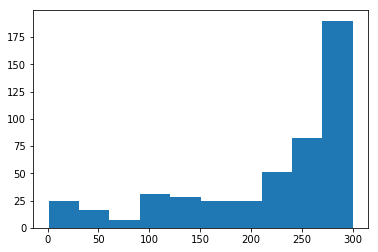

In [5]:
lengths = [len(rmsds)
           for prot, ligands in data.items()
           for ligand, rmsds in ligands.items()]
plt.hist(lengths)

# Glide performance for all ligands

In [6]:
def percentage_native(rmsds, poses = 1, thresh = 2.0):
    hit, total = 0.0, 0.0
    for rmsd in rmsds:
        if None in rmsd: continue
        hit   += any(rmsd[:poses] < thresh)
        total += 1
    return hit / total

class Table:
    def __init__(self, columns):
        self.columns = columns
    
    def __call__(self, data):
        s = ''
        for width, d in zip(self.columns, data):
            d = str(d)[:width-1]
            s += str(d).ljust(width, ' ')
        print s

def performance(rmsds):

    POSE = [0, 1, 3, 10, 30, 100, 300]
    THRESH = [1, 1.5, 2, 2.5, 3, 3.5, 4, 8]

    for thresh in THRESH:
        Y = [percentage_native(rmsds, poses, thresh)
             for poses in POSE]
        plt.plot(Y, label = "< {} rmsd".format(thresh))
    plt.xticks(range(len(POSE)),POSE)
    plt.legend(loc = 4)
    plt.ylabel('Fraction Correct')
    plt.xlabel('Number of Poses Considered')
    plt.title('All Proteins')
    plt.ylim(0, 1)
    plt.xlim(0, len(POSE)-1)
    plt.show()

    # Table
    potential = Table([10]*4)
    potential(['RMSD', 'top 1', 'top 100', 'Potential'])

    for thresh in THRESH:
        potential([thresh,
                   percentage_native(rmsds, 1, thresh),
                   percentage_native(rmsds, 100, thresh), 
                   percentage_native(rmsds, 100, thresh) - percentage_native(rmsds, 1, thresh)
                  ])

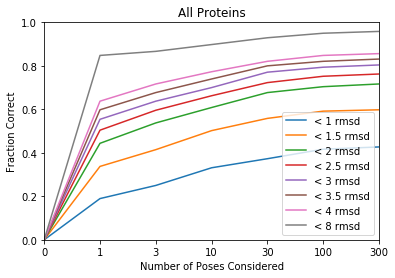

RMSD      top 1     top 100   Potential 
1         0.1895833 0.4166666 0.2270833 
1.5       0.3375    0.5916666 0.2541666 
2         0.44375   0.7041666 0.2604166 
2.5       0.5041666 0.7520833 0.2479166 
3         0.5541666 0.79375   0.2395833 
3.5       0.5979166 0.8208333 0.2229166 
4         0.6375    0.8479166 0.2104166 
8         0.8479166 0.95      0.1020833 


In [7]:
rmsds = [np.array(rmsds)
         for prot, ligands in data.items()
         for ligand, rmsds in ligands.items()]
performance(rmsds)

# Glide performance averaged over targets

In [8]:
def target_performance(top1, top100, labels):
    print 'Top pose is correct', sum(top1) / float(len(top1))
    print 'Top 100 has one correct', sum(top100) / float(len(top100))

    markers = ['o', 'v', 'x', 's']
    f, ax = plt.subplots()
    for i, (_x, _y, _label) in enumerate(zip(top1, top100, labels)):
        plt.scatter(_x, _y, marker = markers[i/10], label = _label)
    plt.xlabel('Top 1', fontsize = 16)
    plt.ylabel('Top 100', fontsize = 16)
    plt.plot(range(2), linestyle='--', c = 'k')
    plt.title('Fraction Near-Native', fontsize = 20)
    ax.set_aspect('equal', 'box')
    plt.legend(bbox_to_anchor=(1.1, 1.05), ncol=2)
    plt.show()

Top pose is correct 0.435490884981
Top 100 has one correct 0.720979331986


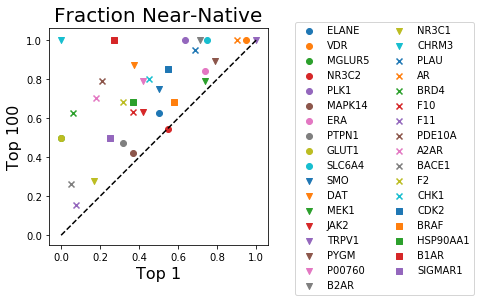

In [9]:
# GScore
top1, top100, labels = [], [], []
for prot, ligands in data.items():
    if prot == '5HT2B': continue
    rmsds = [np.array(rmsds)
             for ligand, rmsds in ligands.items()]
    top1   += [percentage_native(rmsds, 1, 2.0)]
    top100 += [percentage_native(rmsds, 100, 2.0)]
    labels += [prot]
target_performance(top1, top100, labels)

# Performance by family

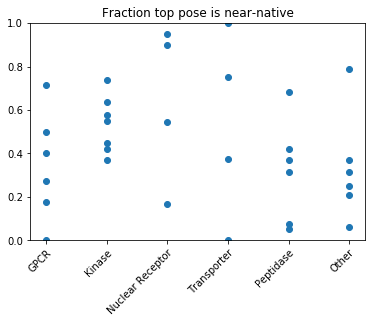

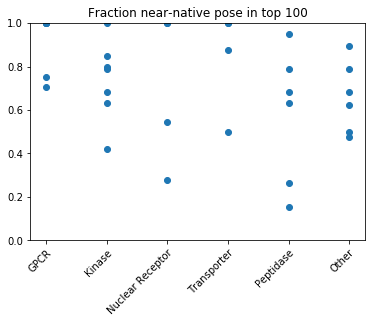

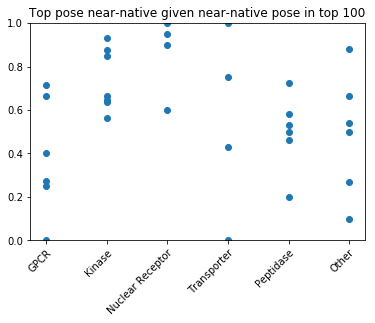

In [18]:
family = {
    'GPCR': ['5HT2B', 'A2AR', 'B1AR', 'B2AR', 'CHRM3','SMO'],
    'Kinase': ['BRAF', 'CDK2', 'CHK1', 'JAK2', 'PLK1', 'MAPK14', 'MEK1'],
    'Transporter': ['SLC6A4', 'GLUT1', 'DAT', 'TRPV1'],
    'Nuclear Receptor': ['NR3C2', 'NR3C1', 'AR', 'VDR'],
    'Peptidase': ['F2', 'F10', 'F11', 'PLAU', 'P00760', 'BACE1'],
    'Other': ['PYGM', 'PTPN1', 'BRD4', 'HSP90AA1', 'PDE10A', 'SIGMAR1']
}
def plot(n1, n2, title):
    order = ['GPCR', 'Kinase', 'Nuclear Receptor', 'Transporter', 'Peptidase', 'Other']
    performance = []
    for name in order:
        performance += [[]]
        for member in family[name]:
            if member in data:
                n = percentage_native([np.array(rmsds) for ligand, rmsds in data[member].items()], n1, 2.0)
                if n2:
                    d = percentage_native([np.array(rmsds) for ligand, rmsds in data[member].items()], n2, 2.0)
                else:
                    d = 1.0
                performance[-1] += [n / d]
            else:
                print member

    x = [_x for i, p in enumerate(performance) for _x in [i] * len(p)]
    y = [_y for p in performance for _y in p]
    plt.scatter(x, y)
    plt.xticks(range(len(order)), order, rotation = 45, ha='right', rotation_mode='anchor')
    plt.title(title)
    plt.ylim(0, 1)
    plt.show()
plot(1, 0, 'Fraction top pose is near-native')
plot(100, 0, 'Fraction near-native pose in top 100')
plot(1, 100, 'Top pose near-native given near-native pose in top 100')